[View in Colaboratory](https://colab.research.google.com/github/ravithejaburugu/IoTAnomalyDetectionKerasTFLSTM/blob/master/WatsonIoTPlatformKerasTFLSTM.ipynb)

In [0]:
import pip

try:
    __import__('keras')
except ImportError:
    pip.main(['install', 'keras']) 
    
try:
    __import__('h5py')
except ImportError:
    pip.main(['install', 'h5py']) 
    
try:
    __import__('ibmiotf')
except ImportError:
    pip.main(['install', 'ibmiotf']) 


In [0]:
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import sklearn
from  sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ibmiotf.application
#from Queue import Queue

%matplotlib inline

In [4]:
!rm watsoniotp.*
!wget https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.healthy.phase_aligned.pickle
!wget https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.broken.phase_aligned.pickle

rm: cannot remove 'watsoniotp.*': No such file or directory
--2018-04-17 08:17:34--  https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.healthy.phase_aligned.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 194639 (190K) [text/plain]
Saving to: ‘watsoniotp.healthy.phase_aligned.pickle’

watsoniotp.healthy. 100%[===================>] 190.08K  --.-KB/s    in 0.03s   

2018-04-17 08:17:35 (6.81 MB/s) - ‘watsoniotp.healthy.phase_aligned.pickle’ saved [194639/194639]

--2018-04-17 08:17:36--  https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.broken.phase_aligned.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.1

In [0]:
data_healthy = pickle.load(open('watsoniotp.healthy.phase_aligned.pickle', 'rb'), encoding='latin1')
data_broken = pickle.load(open('watsoniotp.broken.phase_aligned.pickle', 'rb'), encoding='latin1')

In [0]:
data_healthy = data_healthy.reshape(3000,3)
data_broken = data_broken.reshape(3000,3)

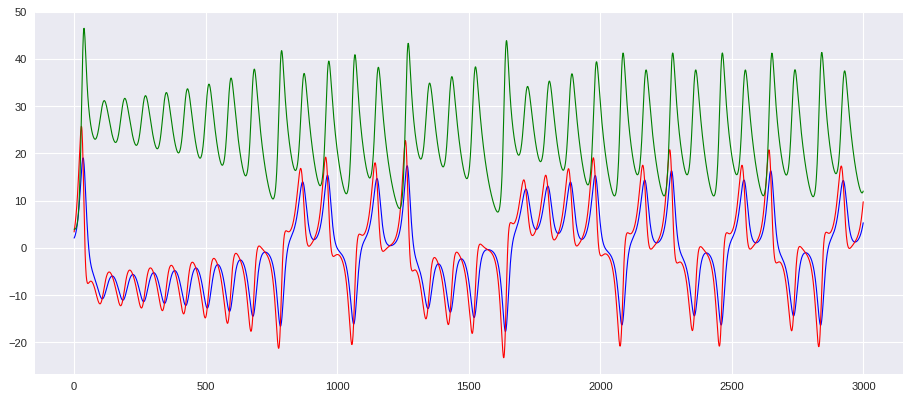

In [8]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy)
#ax.set_ylim(0,energy.max())
ax.plot(range(0,size), data_healthy[:,0], '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy[:,1], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy[:,2], '-', color='green', animated = True, linewidth=1)

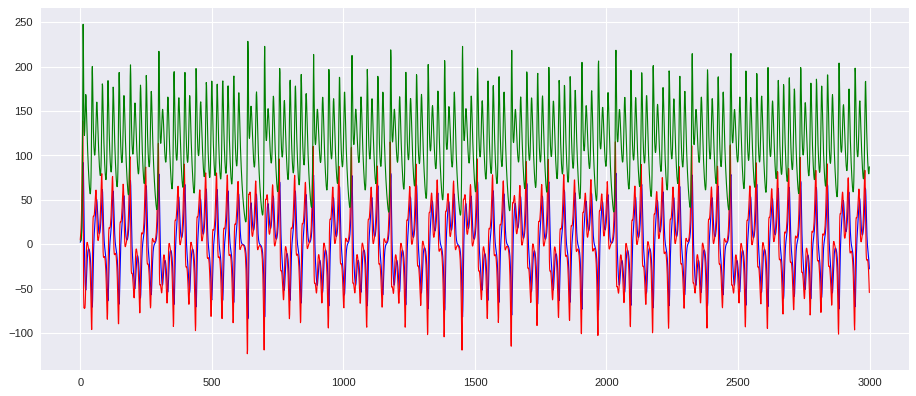

In [9]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy)
#ax.set_ylim(0,energy.max())
ax.plot(range(0,size), data_broken[:,0], '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken[:,1], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken[:,2], '-', color='green', animated = True, linewidth=1)

In [0]:
data_healthy_fft = np.fft.fft(data_healthy)
data_broken_fft = np.fft.fft(data_broken)

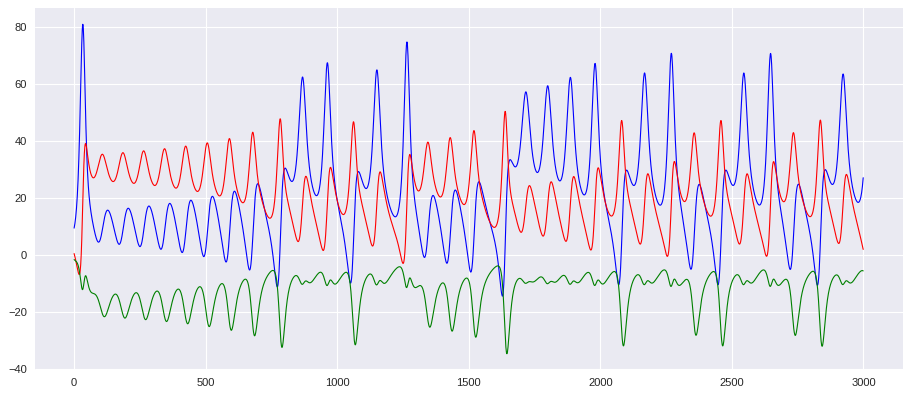

In [11]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy_fft)
ax.plot(range(0,size), data_healthy_fft[:,0].real, '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy_fft[:,1].imag, '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy_fft[:,2].real, '-', color='green', animated = True, linewidth=1)


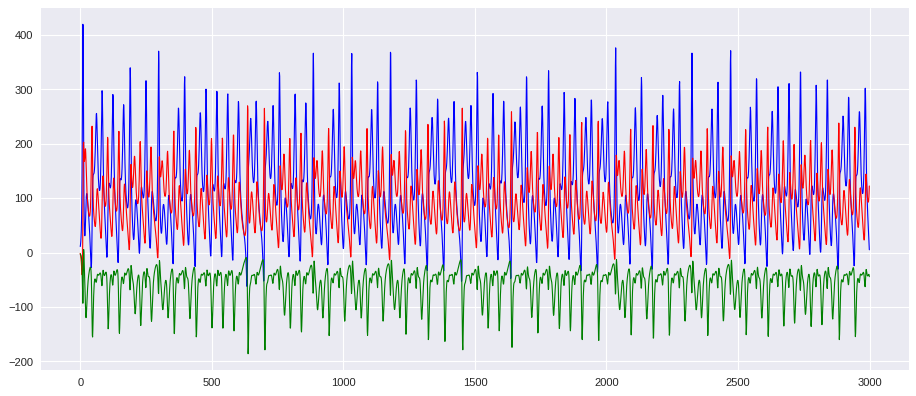

In [12]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy_fft)
ax.plot(range(0,size), data_broken_fft[:,0].real, '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken_fft[:,1].imag, '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken_fft[:,2].real, '-', color='green', animated = True, linewidth=1)


In [0]:
def scaleData(data):
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(data)

In [0]:
data_healthy_scaled = scaleData(data_healthy)
data_broken_scaled = scaleData(data_broken)

In [0]:
timesteps = 10
dim = 3
samples = 3000
data_healthy_scaled_reshaped = data_healthy_scaled
#reshape to (300,10,3)
data_healthy_scaled_reshaped.shape = (int(samples/timesteps),timesteps,dim)

In [0]:
losses = []

def handleLoss(loss):
        global losses
        losses+=[loss]
        print(loss)

In [0]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        handleLoss(logs.get('loss'))

In [0]:
# design network

model = Sequential()
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(Dense(3))
model.compile(loss='mae', optimizer='adam')

def train(data):
    data.shape = (300, 10, 3)
    model.fit(data, data, epochs=50, batch_size=72, validation_data=(data, data), verbose=0, shuffle=False,callbacks=[LossHistory()])
    data.shape = (3000, 3)

def score(data):
    data.shape = (300, 10, 3)
    yhat =  model.predict(data)
    yhat.shape = (3000, 3)
    return yhat

In [0]:
for i in range(20):
    
    print("----------------")
    train(data_healthy_scaled)
    yhat_healthy = score(data_healthy_scaled)
    yhat_broken = score(data_broken_scaled)
    data_healthy_scaled.shape = (3000, 3)
    data_broken_scaled.shape = (3000, 3)


print("----------------broken")
train(data_broken_scaled)
yhat_healthy = score(data_healthy_scaled)
yhat_broken = score(data_broken_scaled)
data_healthy_scaled.shape = (3000, 3)
data_broken_scaled.shape = (3000, 3)

----------------
0.38889062
0.4662462
0.48026344
0.44905874
0.5234556
0.3540516
0.42678037
0.43590233
0.39787552
0.4631828
0.28525615
0.34996858
0.34856236
0.3025316
0.341437
0.22139484
0.2809156
0.2898435
0.28615054
0.2997993
0.24589446
0.26909912
0.26569387
0.25523248
0.2802576
0.20677763
0.2511202
0.2584762
0.24571496
0.27924618
0.19929536
0.24338706
0.24804637
0.23611814
0.25862363
0.19977894
0.23428291
0.23564023
0.23041889
0.24177301
0.20224063
0.22946416
0.22890632
0.22518675
0.23491521
0.19486101
0.22278632
0.22337927
0.21778461
0.23351783
0.18501766
0.21728393
0.2195819
0.2125144
0.22977626
0.18085636
0.2126436
0.21418177
0.20805359
0.220577
0.18135749
0.20842522
0.20833611
0.2044178
0.21168278
0.1819548
0.2046493
0.20379348
0.2006224
0.20593722
0.17988256
0.20080012
0.20038009
0.19681208
0.20268838
0.17739247
0.19751392
0.19710654
0.19383687
0.197738
0.17738731
0.19516842
0.19367427
0.19184259
0.1923747
0.1779539
0.19332938
0.19125351
0.18999672
0.18979383
0.177149
0.19160087

0.14834699
0.16238767
0.15558778
0.15493907
0.14853942
0.14689344
0.15983494
0.15180206
0.15433574
0.14644127
0.14183323
0.15661831
0.15150216
0.15224743
0.14179647
0.13838366
0.1561109
0.14949977
0.15190935
0.14017963
0.1351102
0.15341735
0.1497141
0.150617
0.13817477
0.12945965
0.1524849
0.14750516
0.15212318
0.13742258
0.12487049
0.1451419
0.14283736
0.14477031
0.13676597
0.12518014
0.14341865
0.14054054
0.14575651
0.13463716
0.11953282
0.1407733
0.13832353
0.13898097
0.13365687
----------------
0.12097841
0.13750933
0.13419747
0.13787577
0.1300091
0.115225025
0.13502133
0.13157913
0.13367349
0.12612797
0.110030055
0.13063532
0.12559769
0.12851848
0.121896595
0.109695286
0.12432814
0.120602965
0.12458403
0.11489656
0.09987809
0.11912436
0.115717664
0.11829175
0.108928494
0.09777798
0.1208881
0.114922605
0.120226465
0.1201975
0.09246527
0.12908812
0.12719768
0.118915826
0.11683423
0.10412391
0.11456072
0.10853514
0.123238936
0.10649374
0.09988991
0.120766774
0.12343102
0.12557806
0.1

0.08475623
0.067188874
0.086805336
0.08593105
0.091340154
0.08282134
0.073858574
0.085884534
0.085154384
0.09228352
0.08302874
0.0751181
0.085492164
0.08588825
0.09413903
0.08296161
0.09325091
0.0902093
0.08422145
0.088493094
0.08459642
0.08002421
0.089230575
0.08528175
0.088128954
0.08130021
0.07871062
0.08808369
0.085033715
0.087451935
0.08087168
0.06858521
0.08587032
0.0830362
0.086073846
0.08011091
0.06701065
0.085267186
0.083322726
0.08604983
0.080602564
0.066619754
0.0834637
0.08194078
0.08553285
0.079916224
0.06712566
0.083572045
0.082087494
0.085923076
0.07963873
0.068666846
0.08186683
0.08129627
0.08649743
0.07942768
0.07434138
0.082252055
0.08042875
0.08543657
0.080424264
0.072820015
0.08095158
0.07883828
0.08528225
0.078611106
0.07744764
0.082482405
0.07855794
0.08270288
0.08177363
0.075123206
0.08271078
0.07786278
0.0825758
0.0767885
0.07550117
0.08169178
0.07809231
0.07992208
0.076213956
0.06811998
0.08162234
0.07757285
0.08167502
0.0749268
0.06559329
0.07876973
0.07822578

0.065648146
0.071278706
0.06899367
0.0584227
0.06612369
0.065052785
0.07191115
0.07047317
0.060411375
0.068076834
0.06453726
0.070254356
0.06932057
0.058091667
0.067707576
0.06557671
0.06846579
0.06808048
0.05874631
0.06837489
0.06633765
0.06881303
0.06761647
0.050895497
0.06859872
0.07033126
0.06917998
0.06688241
0.052053027
0.06583287
0.066786356
0.07377089
0.06388795
0.044698723
0.06490829
0.064644285
0.06746951
0.066639096
0.046938095
0.06571991
0.06565127
0.07007249
0.06456596
0.04864582
0.06346122
0.060366265
0.06686337
0.06554336
0.053586613
0.06528661
0.06566577
0.06696836
0.069048606
0.04663482
0.06083366
0.0595001
0.06566834
0.065529205
0.059221838
0.061782137
0.060772855
0.06482443
0.06593561
0.049602643
0.06268718
0.059035964
0.06616698
0.06851983
0.057932846
0.061782923
0.057882097
0.062279113
0.063159704
0.05170078
0.062322684
0.060439307
0.06269744
0.06777495
0.04848216
0.06097579
0.058168396
0.06226819
0.061975885
0.05003064
0.058870777
0.058350366
0.060805704
0.0652231

0.028899388
0.042782154
0.042279467
0.044083696
0.042686243
0.033053294
0.04409083
0.04513639
0.04885468
0.04293796
0.035352174
0.042143434
0.040209252
0.04341756
0.040891584
0.03815954
0.042311393
0.044988096
0.045992475
0.04070918
0.03142091
0.042440422
0.041111276
0.0428784
0.04019324
0.033724103
0.04382072
0.04559896
0.046260104
0.040055618
0.035989456
0.042469826
0.037817877
0.04133551
0.043000698
0.036589064
0.041415572
0.040806737
0.04098288
0.03695168
0.03544327
0.03860505
0.035555825
0.038185496
0.036641493
0.03137496
0.036887713
0.037166715
0.03961755
0.037727013
0.02611099
0.038708944
0.037666958
0.040261135
0.036147047
0.027066372
0.03834627
0.037976615
0.039058425
0.03559263
0.026568465
0.038934402
0.04010851
0.042701095
0.034958545
0.03298561
0.039769426
0.04076981
0.042443946
0.040282946
0.03173604
0.03556749
0.03530005
0.040895928
0.036269266
0.032740083
0.038027916
0.034982704
0.0425257
0.03863765
0.037130125
0.037455533
0.037921593
0.043168116
0.0361873
0.039287757
0.

0.049287524
0.042330325
0.033562772
0.043425903
0.036875878
0.036343522
0.04140777
0.02914238
0.0253685
0.043060295
0.03961654
0.030969398
0.03596189
0.037260745
0.03259525
0.035760786
0.044535253
0.029952886
----------------
0.02837946
0.05183889
0.059238095
0.0507374
0.038976554
0.038141105
0.048917394
0.04555554
0.03834719
0.029575156
0.055773854
0.0384261
0.036061123
0.04593573
0.0393433
0.04156443
0.040018704
0.046829935
0.044301193
0.03460746
0.025465878
0.042811394
0.041176304
0.03838478
0.027650809
0.046683233
0.037681077
0.035070512
0.04541487
0.033987228
0.04364969
0.038593974
0.043764625
0.04359065
0.033846203
0.025091376
0.044687264
0.045943458
0.03897992
0.028111553
0.048046425
0.047276694
0.041098062
0.038396258
0.030155385
0.06344508
0.046971023
0.0316696
0.032040067
0.03564642
0.036363248
0.032881007
0.034171958
0.038623337
0.032053735
0.02232939
0.043521125
0.047639087
0.040984612
0.034944985
0.047692936
0.04302928
0.032872625
0.033961102
0.028614493
0.043073274
0.0384

0.024444886
0.028112957
0.024448117
0.018684633
0.027510216
0.02709302
0.028874792
0.022783453
0.022466779
0.028829655
0.02858964
0.030673686
0.025520599
0.028483547
0.024654415
0.030947099
0.036485545
0.024827577
0.030490458
0.032148056
0.030332187
0.031965435
0.035365853
0.028728902
0.032142453
0.030865857
0.02979462
0.023328574
0.02689473
0.03492991
0.030664764
0.027249184
0.03115417
0.024744878
0.026877016
0.024856512
0.025489464
0.020411804
0.02486965
0.029971441
0.026423028
0.031679034
0.025529027
0.030857615
0.028428473
0.03253085
0.028592573
0.028234355
0.018605718
0.028271586
0.028277218
0.024733666
0.021687353
0.025506843
0.023588415
0.024210691
0.026278468
0.026136091
0.020187529
0.026372192
0.02610793
0.02543342
0.021046853
0.025938012
0.025315842
0.024305956
0.027034048
0.021287903
0.020972453
0.024952864
0.023594692
0.025457747
0.025243064
0.020237379
0.023284035
0.023179524
0.025504066
0.02146867
----------------
0.020859098
0.024521278
0.025146151
0.027861731
0.02212857

0.025254553
0.029459868
0.027304944
0.025676591
0.023508705
0.020341722
0.030036427
0.028699458
0.022140902
0.025285749
0.026112977
0.023931311
0.025016531
0.022676954
0.024240792
0.018872216
0.021875344
0.02325315
0.02263727
0.018691266
0.018582897
0.02378797
0.019806597
0.023633787
0.023741731
0.022735922
0.02674411
0.026788235
0.028418072
0.02117443
0.029102644
0.024247644
0.025512444
0.02649145
0.026561504
0.018062852
0.02550002
0.026194267
0.026525911
0.025602372
0.022885442
0.021764906
0.023798816
0.028045135
0.020470394
0.023217075
0.02455668
0.026988715
0.029973798
0.022544427
0.0257971
0.022626821
0.02401417
0.028065575
0.026871793
0.022293108
0.023465833
0.025634937
0.026593259
0.024158396
0.025292376
0.021803413
0.022843368
0.027349662
0.023036635
0.025114084
0.023292966
0.025674399
0.025926135
0.02180209
0.023192741
0.021138992
0.022505453
0.02657011
0.020698415
0.025269791
0.02224886
0.025458934
0.028759321
0.02030804
0.028812839
0.022752844
0.023855066
0.025747815
0.02742

0.026379872
0.02135625
0.021596402
0.016283961
0.023610774
0.022195492
0.022111561
0.019638753
0.015916891
0.020280385
0.019198136
0.021109572
0.018352255
0.017512156
0.020667024
0.023202784
0.025388734
0.017804919
0.019859776
0.02220679
0.021263411
0.02385349
0.023860833
0.01620446
0.021108564
0.022388905
0.02289726
0.01692498
0.024869816
0.023686744
0.024507029
0.030765176
0.018270547
0.030420542
0.023350984
0.027667886
0.030717485
0.020899458
0.020399278
0.030064357
0.031540442
0.025841465
0.02235728
0.021540664
0.022526689
0.021270314
0.026778733
0.016883446
0.015656328
0.02702836
0.023413476
0.020262398
0.019650737
